In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from scene_synthesis.datasets.nuScenes import NuScenesDataset
from scene_synthesis.datasets.utils import collate_test
from scene_synthesis.networks.autoregressive_transformer import AutoregressiveTransformer

def to_numpy(data: dict):
    for k in data:
        if isinstance(data[k], torch.Tensor):
            data[k] = data[k].squeeze()
            if not data[k].shape:
                data[k] = data[k].item()
            else:
                data[k] = data[k].numpy()
        elif isinstance(data[k], dict):
            to_numpy(data[k])


In [2]:
plt.ion()
dataset = NuScenesDataset("/media/yifanlin/My Passport/data/nuScene-processed", train=True)
axes_limit = 40
cat2color = {1: 'red', 2: 'blue', 3: 'green'}
model = AutoregressiveTransformer()
model.load_state_dict(torch.load('./ckpts/07-24-11:35:59'))


<All keys matched successfully>

In [22]:
data = dataset[5]
input_data, length, _ = collate_test([data])
for k in data:
    data[k] = input_data[k].squeeze(0).numpy()


In [26]:
condition = {
    "category": 3,  # int
}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


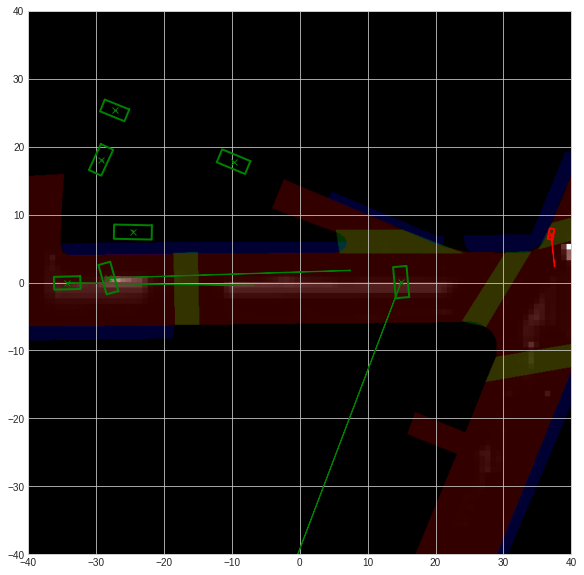

In [36]:
preds, probs = model.generate(input_data, length, condition)
to_numpy(preds)
category = preds['category']
if category != 0:
    data['category'] = np.concatenate([data['category'], np.array([preds['category']])], axis=0)
    data['location'] = np.concatenate([data['location'], preds['location'].reshape(1, -1)], axis=0)
    data['bbox'] = np.concatenate([data['bbox'], np.concatenate([preds['wl'], np.array([preds['theta']])], axis=0).reshape(1, -1)], axis=0)
    data['velocity'] = np.concatenate([data['velocity'], np.array([[preds['s'] * preds['moving'], preds['omega']]])], axis=0)
    idx = list(range(len(data['category'])))
    idx.sort(key=lambda i: (-data['location'][i, 1], data['location'][i, 0]))
    for k in ['category', 'location', 'bbox', 'velocity']:
        data[k] = data[k][idx]
    input_data = {}
    input_data['category'] = torch.tensor(data['category'])
    for k in ['location', 'bbox', 'velocity', 'map']:
        input_data[k] = torch.tensor(data[k], dtype=torch.float)
    input_data, length, _ = collate_test([input_data], keep_all=True)

    _, ax = plt.subplots(figsize=(10, 10))
    map_layers = np.stack(data['map'][:3], axis=-1) * 0.2
    prob_map = probs['location'].log_prob(torch.tensor(np.arange(10000))).reshape(100, 100).numpy()
    prob_map = np.exp(prob_map)
    prob_map = np.kron(prob_map, np.ones((8, 8)))
    prob_map /= prob_map.sum()
    map_layers += prob_map[..., None] / prob_map.max()
    ax.imshow(map_layers, extent=[-axes_limit, axes_limit, -axes_limit, axes_limit])
    for i in range(length.item()):
        if data['category'][i] != 0:
            color = cat2color[data['category'][i]]
            loc = data['location'][i]
            ax.plot(loc[0], loc[1], 'x', color=color)
            w, l, theta = data['bbox'][i]
            corners = np.array([[l / 2, w / 2],
                                [-l / 2, w / 2],
                                [-l / 2, -w / 2],
                                [l / 2, -w / 2],
                                [l / 2, w / 2]])
            rotation = np.array([[np.cos(theta), np.sin(theta)],
                                 [-np.sin(theta), np.cos(theta)]])
            corners = np.dot(corners, rotation) + loc
            ax.plot(corners[:, 0], corners[:, 1], color=color, linewidth=2)
            speed, omega = data['velocity'][i]
            rotation = np.array([[np.cos(omega), np.sin(omega)],
                                 [-np.sin(omega), np.cos(omega)]])
            velocity = np.dot(np.array([speed, 0]), rotation)
            ax.arrow(loc[0], loc[1], velocity[0] * 5, velocity[1] * 5, color=color, width=0.05)
    ax.set_xlim([-axes_limit, axes_limit])
    ax.set_ylim([-axes_limit, axes_limit])


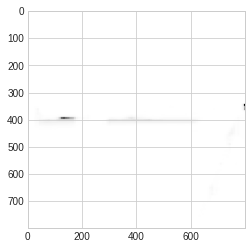

In [35]:
plt.imshow(prob_map)

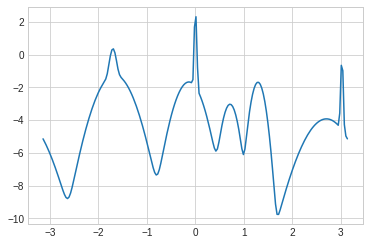

In [34]:
x = torch.linspace(-np.pi, np.pi, 200)
y = probs['theta'].log_prob(x[..., None])
plt.plot(x, y)

In [ ]:
probs['theta'].log_prob(torch.tensor(0))